# Test Six for the Classical SRNN

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from ClassicalModels.ClassicalSRNNs import ClassicalSRNN
from ClassicalModels.ClassicalSRNNs import SuportFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
from GradientFreeOptimizers.Optimizers import MCSOptimizer
import GradientFreeOptimizers.Helpers as hp

## Test Six

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='ClassicalSRNNTest1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(10000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 10000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.004080481176836049, 0.06596289908127698]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=10
batchSize=4

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
#print('X=',torch.squeeze(X))
#print('Y=',torch.squeeze(Y))

Train Data Size: 799


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
#print('X=',torch.squeeze(X))
#print('Y=',torch.squeeze(Y))

Test Data Size: 199


### Define the SRNN

#### Get neccesary functions

In [13]:
srnnTestSup=SuportFunction()

In [14]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [15]:
init_rnn_state=srnnTestSup.get_init_state_fun()
get_params=srnnTestSup.get_get_params_fun()
rnn=srnnTestSup.get_forward_fn_fun()
predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [16]:
inputSize=outputSize=1
hiddenSize=6

In [17]:
net=ClassicalSRNN(inputSize,hiddenSize,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [18]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([40, 1]), 1, torch.Size([4, 6]))

In [19]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0041],
        [0.0660]])
preY= [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


In [20]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0041), tensor(0.0660), tensor(-1.3199e-05), tensor(2.8045e-08), tensor(-3.4623e-09), tensor(1.0193e-11), tensor(-1.8250e-12)]


### Train the network

#### Parameters

In [21]:
num_epochs= 600

In [22]:
maxLevyStepSize=[1.0,1.0,0.1,1.0,1.0]

#### Loss function

In [23]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [24]:
mcs=MCSOptimizer(net.params,lossFunc,trainIter,\
    maxLevyStepSize=maxLevyStepSize,randInit=True,\
    nestNum=40,epochToGeneration=lambda x:max(int(x/100),1))

#### Initial loss

In [25]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.4927547097206116
Initial Test Loss: 0.5304158449172973


#### Training

TestLoss 0.078280
Prediction:
 [tensor(0.0041), tensor(0.0660), tensor(0.9430), tensor(-0.3878), tensor(0.8811), tensor(-0.2720), tensor(0.9358), tensor(-0.4014), tensor(0.8714), tensor(-0.2486), tensor(0.9451)]
Answer:
 [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


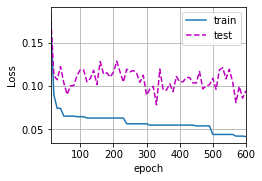

In [26]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    with torch.no_grad():
        trainLoss,_ = mcs.step()
        testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
        if (epoch + 1) % 10 == 0:
            print(predict(preX))
            animator.add(epoch + 1, [trainLoss,testLoss])
        l_epochs.append([trainLoss,testLoss])
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

In [27]:
l_epochs[-1]

[0.0415128730237484, 0.0945480301976204]

### Visualize the performance

#### One Step Prediction

In [28]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))

X= tensor([[ 1.0216, -0.3515,  1.1335, -0.9041,  0.1957,  0.6752,  0.4205,  0.9550,
         -0.1506,  1.2547],
        [-0.4821,  0.9933, -0.5261,  0.9106, -0.3186,  1.1310, -0.8866,  0.2390,
          0.6541,  0.4727],
        [-0.0956,  0.6809,  0.3223,  1.0589, -0.4730,  1.0045, -0.5545,  0.8709,
         -0.2283,  1.1883],
        [ 0.5618,  0.6684,  0.5431,  0.7875,  0.2947,  1.1147, -0.6512,  0.7408,
          0.0364,  1.2204]])
Prediction= tensor([-0.4051,  0.8275,  1.0246,  0.6336,  0.9052, -0.5598,  0.2300,  0.3259,
        -0.8897,  0.7859,  0.8632,  0.5804,  0.3437, -0.3563, -0.6286,  0.0609,
         0.8948,  0.9165,  0.8357,  0.9037,  0.2595, -0.8814, -0.5882, -0.7609,
         0.7611,  0.3718,  0.7637,  0.6822, -0.3635,  0.8653, -0.2579,  0.0571,
         0.9913,  0.3082,  0.9537,  0.9914, -1.1302,  0.6885, -1.0009, -1.0331])
Y= tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  1.1335, -0.5261,  0.3223,  0.5431,
        -0.9041,  0.9106,  1.0589,  0.7875,  0.1957, -0.3186, -0

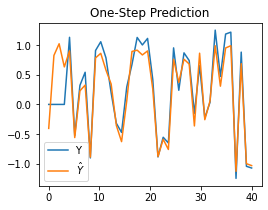

In [29]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [34]:
prefixSize=10
totalSize=20
testShift=int(len(hmap)*(1-testSetRatio))

In [35]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

20

In [36]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

20

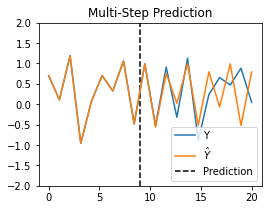

In [37]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

# End of the test